In [218]:
import numpy as np
import pandas as pd
np.random.seed(100)

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pysensors as ps

import imageio.v3 as iio
from IPython.display import Image, display

# Data Generation

In [219]:
def generate_simple_flow(n_timesteps, nx, ny):
    # create a moving Gaussian "blob" that travels across the domain.
    data = np.zeros((n_timesteps, nx, ny))
    x = np.linspace(0, 1, nx)
    y = np.linspace(0, 1, ny)
    Xgrid, Ygrid = np.meshgrid(x, y, indexing='ij')

    for t in range(n_timesteps):
        # The center of the blob moves linearly through the domain.
        cx = 0.8 - 0.6 * (t / n_timesteps)
        cy = 0.2 + 0.6 * (t / n_timesteps)
        data[t] = np.exp(-((Xgrid - cx)**2 + (Ygrid - cy)**2) / 0.01)

    return data

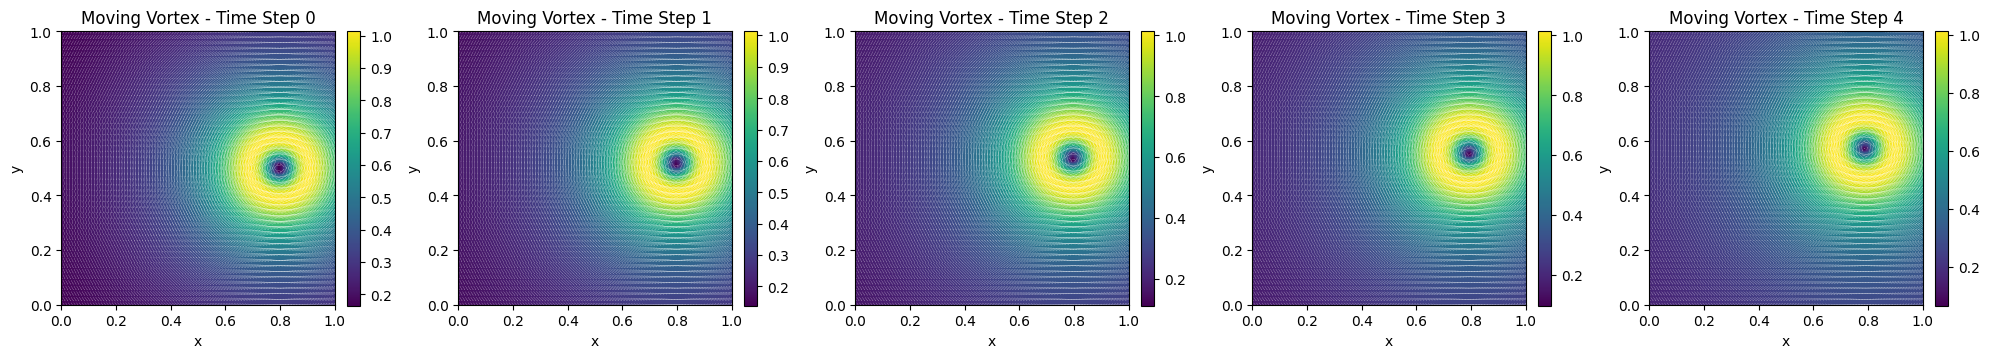

In [220]:
def generate_moving_vortex(n_timesteps, nx, ny, lx=1, ly=1, period=100, plot_series=False, plot_interval=1):
    """
    Generate a moving vortex flow field based on the Lamb–Oseen vortex solution.
    The instantaneous velocity field is computed as:
    
        u(x,y,t) = - (Gamma/(2π)) * ( (y - y0(t)) / r² ) * [1 - exp(-r²/r_c²)]
        v(x,y,t) =   (Gamma/(2π)) * ( (x - x0(t)) / r² ) * [1 - exp(-r²/r_c²)]
        
    where r² = (x - x0(t))² + (y - y0(t))².
    """
    # Vortex parameters
    Gamma = 1.0
    r_c = 0.1
    x_center = 0.5
    y_center = 0.5
    r_move = 0.3  # amplitude of the center's circular motion

    data = np.zeros((n_timesteps, nx, ny))
    u_field = np.zeros((n_timesteps, nx, ny))
    v_field = np.zeros((n_timesteps, nx, ny))
    
    # Define physical domain: x in [0,lx], y in [0,ly]
    x = np.linspace(0, lx, nx)
    y = np.linspace(0, ly, ny)
    # Use 'ij' indexing: first index corresponds to x, second to y.
    Xgrid, Ygrid = np.meshgrid(x, y, indexing='ij')
    
    for t in range(n_timesteps):
        theta = 2 * np.pi * t / period
        x0 = x_center + r_move * np.cos(theta)
        y0 = y_center + r_move * np.sin(theta)
        
        dx = Xgrid - x0
        dy = Ygrid - y0
        r2 = dx**2 + dy**2
        # Avoid division by zero:
        r2[r2 == 0] = 1e-10
        
        factor = 1 - np.exp(-r2 / (r_c**2))
        u = - (Gamma / (2 * np.pi)) * (dy / r2) * factor
        v =   (Gamma / (2 * np.pi)) * (dx / r2) * factor
        
        u_field[t] = u
        v_field[t] = v
        data[t] = np.sqrt(u**2 + v**2)
    
    if plot_series:
        fig, axes = plt.subplots(1, n_timesteps, figsize=(4 * n_timesteps, 4))
        for t in range(0, n_timesteps, plot_interval):
            ax = axes[t]
            
            # Since data[t] is stored as (nx, ny) with x in axis 0 and y in axis 1,
            # we transpose it so that imshow interprets the first dimension as y (vertical)
            im = ax.imshow(data[t].T, origin='lower', extent=[0,lx,0,ly], cmap='viridis')
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

            # The quiver uses Xgrid and Ygrid from meshgrid with indexing='ij',
            ax.quiver(Xgrid, Ygrid, u_field[t], v_field[t], color='white', scale=10, width=0.0007, pivot='mid')
            ax.set_title(f"Moving Vortex - Time Step {t}")
            ax.set_xlabel("x")
            ax.set_ylabel("y")
        
        plt.tight_layout()
        plt.show()    
        
    return u_field, v_field

_ = generate_moving_vortex(5, 100, 50, plot_series=True, plot_interval=1)

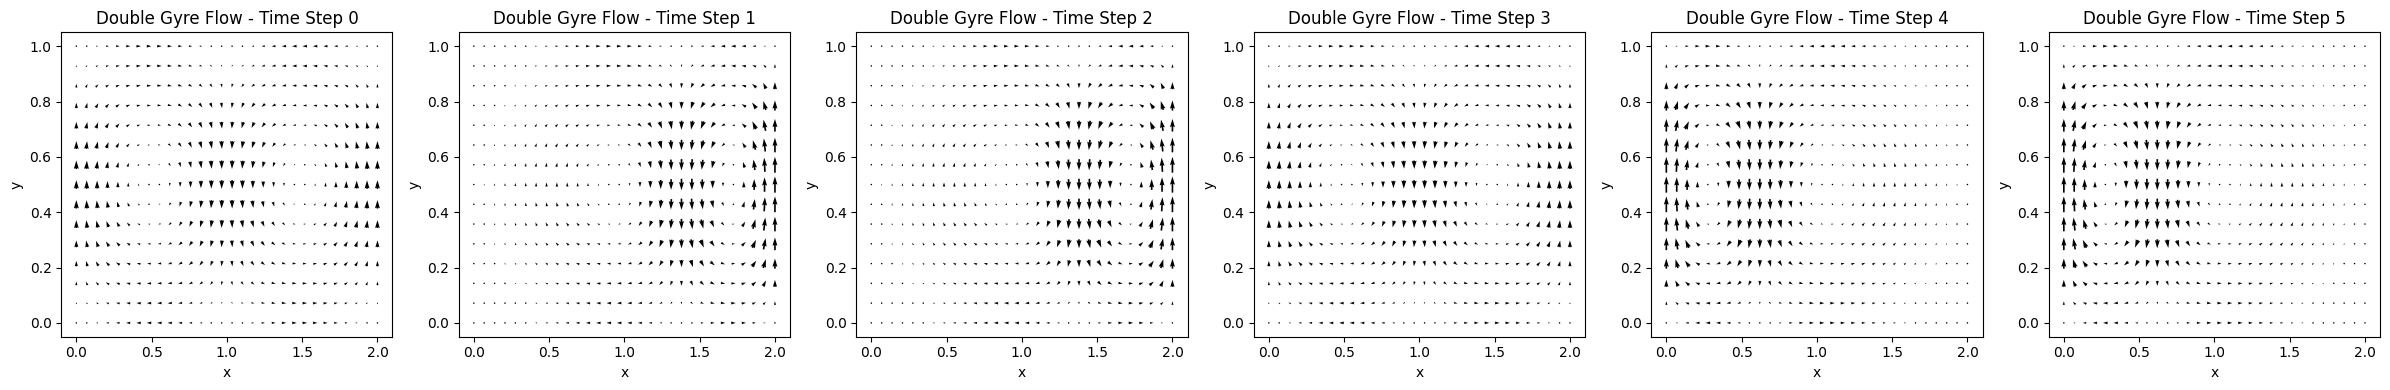

In [221]:
def generate_double_gyre_flow(n_timesteps, nx, ny, lx=2, ly=1,
                              A=0.1, epsilon=0.25, period=20, 
                              plot_series=False):
    """   
    The double gyre is defined on the domain x ∈ [0,2] and y ∈ [0,1]. Its velocity field is given by:
    
        f(x,t) = ε sin(ω t) x² + (1 - 2ε sin(ω t)) x
        u(x,y,t) = -π A sin(π f(x,t)) cos(π y)
        v(x,y,t) =  π A cos(π f(x,t)) sin(π y) [2ε sin(ω t) x + (1 - 2ε sin(ω t))]
    
    Parameters:
      n_timesteps : Number of timesteps.
      nx, ny : Number of spatial grid points in x and y directions.
      A : Amplitude of the velocity.
      epsilon : Strength of the time-periodic oscillation.
      period : Number of intervals for flow to repeat
      plot_series 
    
    Returns:
       u_field, v_field 
    """
    omega = 2*np.pi / period

    data    = np.zeros((n_timesteps, nx, ny))
    u_field = np.zeros((n_timesteps, nx, ny))
    v_field = np.zeros((n_timesteps, nx, ny))

    x = np.linspace(0, lx, nx)
    y = np.linspace(0, ly, ny)

    Xgrid, Ygrid = np.meshgrid(x, y, indexing='ij')
    
    for t in range(n_timesteps):
        # Time variable (assuming unit time steps)
        time = t
        sin_omega_t = np.sin(omega * time)
        
        # Define the function f(x,t) and its derivative with respect to x:
        # f(x,t) = ε sin(ω t) x² + (1 - 2ε sin(ω t)) x
        f = epsilon * sin_omega_t * Xgrid**2 + (1 - 2*epsilon*sin_omega_t) * Xgrid
        dfdx = 2 * epsilon * sin_omega_t * Xgrid + (1 - 2*epsilon*sin_omega_t)
        
        # Compute velocity components
        u = - np.pi * A * np.sin(np.pi * f) * np.cos(np.pi * Ygrid)
        v =   np.pi * A * np.cos(np.pi * f) * np.sin(np.pi * Ygrid) * dfdx
        
        u_field[t] = u
        v_field[t] = v
        data[t] = np.sqrt(u**2 + v**2)
    
    if plot_series:
        fig, axes = plt.subplots(1, n_timesteps, figsize=(4 * n_timesteps, 4))
        for t in range(0, n_timesteps, 1):
            ax = axes[t]
            
            # Plot magnitute
            # im = ax.imshow(data[t].T, origin='lower', extent=[0,lx,0,ly], cmap='viridis')
            # plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            
            # Plot direction
            ax.quiver(Xgrid, Ygrid, u_field[t], v_field[t], color='black', 
                       scale_units='xy', scale=10, width=0.005, pivot='mid')
            
            ax.set_title(f"Double Gyre Flow - Time Step {t}")
            ax.set_xlabel("x")
            ax.set_ylabel("y")
        
        plt.tight_layout()
        plt.show()
    
    return u_field, v_field


# Generate the double gyre flow data over 50 timesteps on a 100x50 grid.
_ = generate_double_gyre_flow(
    n_timesteps=6, nx=30, ny=15, lx=2, ly=1,
    A=0.1, epsilon=0.5, 
    period=6,
    plot_series=True
)


# Data Transformation

In [222]:
def rotate_data_90(data):
    """
    Rotate each snapshot by 90 degrees counterclockwise.
    
    Parameters
    ----------
    data : np.ndarray of shape (n_timesteps, nx, ny)
    """
    # We'll collect each rotated snapshot, then stack them back into an array.
    data_rotated_list = []
    for t in range(data.shape[0]):
        # Rotate data[t] (shape (nx, ny)) by 90 deg counterclockwise
        # np.rot90() outputs shape (ny, nx)
        slice_rot = np.rot90(data[t])
        data_rotated_list.append(slice_rot)
    
    # Stack them along the time dimension again
    data_rotated = np.stack(data_rotated_list, axis=0)
    return data_rotated


In [223]:
def reflect_data_y(data):
    """
    Reflect each snapshot about the horizontal midline in y (about y = L_y/2).
    
    Parameters
    ----------
    data : np.ndarray of shape (n_timesteps, nx, ny)
    """
    data_reflected = data[..., ::-1]
    return data_reflected

Original Data:
[[[ 1  2  3]
  [ 4  5  6]
  [ 7  8  9]
  [10 11 12]]]

Reflected Data (about y-mid domain):
[[[ 3  2  1]
  [ 6  5  4]
  [ 9  8  7]
  [12 11 10]]]

Rotated Data (90° counterclockwise):
[[[ 3  6  9 12]
  [ 2  5  8 11]
  [ 1  4  7 10]]]


array([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]])

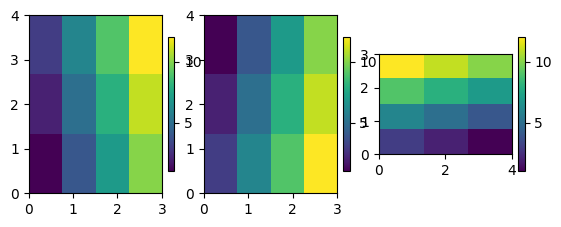

In [224]:
# Test/visulaization 
data = np.array([[
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9],
    [10, 11, 12]
]])

print("Original Data:")
print(data)

data_reflected = reflect_data_y(data)
print("\nReflected Data (about y-mid domain):")
print(data_reflected)

data_rotated = rotate_data_90(data)
print("\nRotated Data (90° counterclockwise):")
print(data_rotated)

fig, axes = plt.subplots(1, 3)
im = axes[0].imshow(data.T, origin='lower', extent=[0, 3, 0, 4], cmap='viridis')
plt.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)
im = axes[1].imshow(data_reflected.T, origin='lower', extent=[0, 3, 0, 4], cmap='viridis')
plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
im = axes[2].imshow(data_rotated.T, origin='lower', extent=[0, 4, 0, 3], cmap='viridis')
plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)

data.reshape(1, 4 * 3)

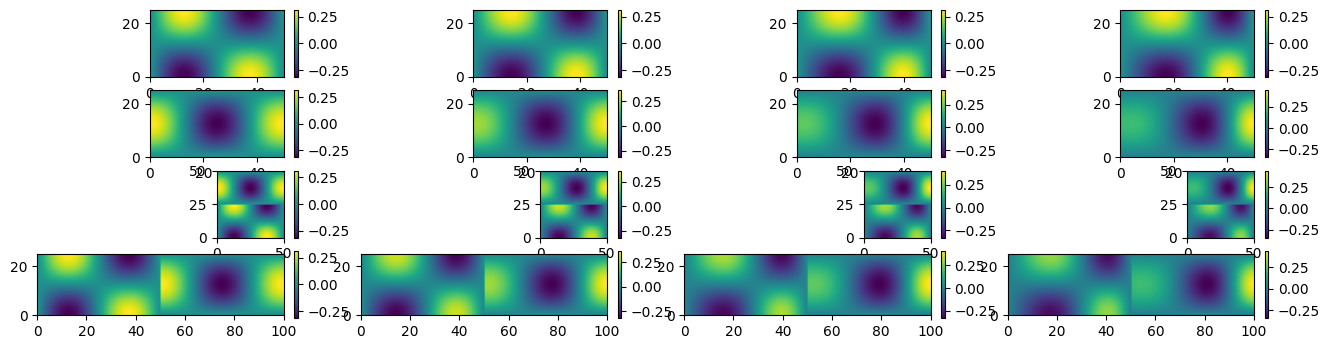

In [225]:
def combine_vector_fields(u_field, v_field, horizontal_concat=True):
    """
    Combine two vector fields (u and v) into a single augmented snapshot.
    
    Parameters:
      u_field : np.ndarray, shape (n_timesteps, nx, ny)
      v_field : np.ndarray, shape (n_timesteps, nx, ny)
      horizontal_concat : bool, optional
             True will concatenate side by side (axis=2),
             resulting in shape (n_timesteps, nx, 2*ny).
             False will concatenate top-to-bottom (axis=1),
             resulting in shape (n_timesteps, 2*nx, ny).
    """
    if horizontal_concat:
        combined_field = np.concatenate((u_field, v_field), axis=2)
    else:
        combined_field = np.concatenate((u_field, v_field), axis=1)
    
    return combined_field


n_timesteps = 4
nx, ny= 50, 25
u_field, v_field = generate_double_gyre_flow(
    n_timesteps=n_timesteps, nx=nx, ny=ny
)

combined_field_h = combine_vector_fields(u_field, v_field)
combined_field_v = combine_vector_fields(u_field, v_field, horizontal_concat=False)


fig, axes = plt.subplots(4, n_timesteps, figsize=(4 * n_timesteps, 4))
for t in range(0, n_timesteps, 1):
    for i, data in enumerate([u_field, v_field, combined_field_h, combined_field_v]):
        ax = axes[i, t]
        # Plot magnitute
        _, t_nx, t_ny = data.shape
        im = ax.imshow(data[t].T, origin='lower', extent=[0, t_nx, 0, t_ny], cmap='viridis')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)


In [226]:
def map_sensor_to_original(sensor_coords, combined_shape, horizontal_concat=True):
    """
    Map sensor coordinates from a combined (augmented) domain back to the original domain.
    
    Parameters:
      sensor_coords : Each row is a coordinate [i, j] in the combined domain.
      combined_shape : The shape (n_rows, n_cols) of the combined data.
          For horizontal concatenation, this should be (nx, 2*ny_orig).
          For vertical concatenation, this should be (2*nx_orig, ny).
      mode : 'horizontal' or 'vertical'. Default is 'horizontal'.
    
    Returns:
      mapped_coords : The sensor coordinates mapped back to the original grid.
          
    Explanation:
      - In horizontal mode, if a sensor’s column index j is ≥ ny_orig,
        then its original column index is j - ny_orig (while the row index stays the same).
      - In vertical mode, if a sensor’s row index i is ≥ nx_orig,
        then its original row index is i - nx_orig (while the column index stays the same).
    """
    mapped_coords = sensor_coords.copy() 
    
    if horizontal_concat:
        # combined_shape[1] is 2 * ny_orig.
        ny_combined = combined_shape[1]
        ny_orig = ny_combined // 2
        for idx, (i, j) in enumerate(sensor_coords):
            if j >= ny_orig:
                mapped_coords[idx, 1] = j - ny_orig
            # else: keep the same
    else:
        # combined_shape[0] is 2 * nx_orig.
        nx_combined = combined_shape[0]
        nx_orig = nx_combined // 2
        for idx, (i, j) in enumerate(sensor_coords):
            if i >= nx_orig:
                mapped_coords[idx, 0] = i - nx_orig
    
    return mapped_coords

In [227]:
def to_complex_cartesian(u, v):
    return u + 1j * v

In [228]:
def to_complex_polar(u, v):
    r = np.sqrt(u**2 + v**2)
    theta = np.arctan2(v, u)
    return r * np.exp(1j * theta)

In [229]:
def get_sliding_intervals(n_timesteps, window, step):
    """
    Return a list of (start, end) pairs for sliding windows.
      - n_timesteps: total number of time steps (e.g. 100)
      - window:      length of each window     (e.g. 20)
      - step:        shift between windows     (e.g. 5)
    """
    intervals = []
    end = window
    while end <= n_timesteps:
        start = end - window
        intervals.append((start, end))
        end += step
    return intervals

In [230]:
def split_augmented(X_aug, nx_c, ny_c, horizontal_concat=True):
    """
    Split augmented snapshots back into u and v arrays.
      nx_c, ny_c  = shape of combined snapshot (not original!)
    """
    if horizontal_concat:
        # X_aug columns = nx_c * ny_c = nx * (2ny)
        u_flat, v_flat = np.split(X_aug, 2, axis=1)
        nx_u, ny_u = nx_c, ny_c          # original dims
    else:
        # vertically stacked → first nx rows are u, next nx rows are v
        nx_orig = nx_c // 2              # recover original nx
        half    = nx_orig * ny_c
        u_flat  = X_aug[:, :half]
        v_flat  = X_aug[:, half:]
        nx_u, ny_u = nx_orig, ny_c

    u = u_flat.reshape(-1, nx_u, ny_u)
    v = v_flat.reshape(-1, nx_u, ny_u)
    return u, v


# Plotting

In [231]:
def plot_optimal_sensors(nx, ny,
                         data_interval, sensor_coords, 
                         ax, plot_title, plot='imshow'):
        
    if plot == 'imshow':
        # For visualization, use mean
        avg_field = data_interval.mean(axis=0)
        im = ax.imshow(avg_field.T, origin='lower', extent=[0, nx, 0, ny], cmap='viridis')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    elif plot == 'quiver':
        # expect a tuple/list (u, v) with shape (T, nx, ny) or (nx, ny)
        u_field, v_field = data_interval

        # if time-dependent, collapse along time axis
        if u_field.ndim == 3:
            u_field = u_field.mean(axis=0)
            v_field = v_field.mean(axis=0)

        # build grid in the SAME coordinates as imshow / sensors
        X, Y = np.meshgrid(np.arange(nx), np.arange(ny), indexing='ij')

        ax.quiver(X, Y, u_field, v_field,
                  color='black',
                  scale_units='xy', scale=None,
                  width=0.005, pivot='mid')


    sensor_x = sensor_coords[:, 0] 
    sensor_y = sensor_coords[:, 1] 

    ax.scatter(sensor_x, sensor_y, 
                color='red', marker='o', s=50)
    ax.set_title(plot_title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

In [232]:
def plot_all_intervals(
    data,
    nx, ny,
    intervals,
    sensor_coords_list
):
    """
    Plot one subplot per interval.
    """
    plot = "imshow"
    if type(data) is tuple:
        plot = 'quiver'
    elif np.iscomplexobj(data):
        data = (np.real(data), np.imag(data))
        # Force mode to imshow for now.
        plot = 'quiver'

    n = len(intervals)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4))
    for ax, coords, (s, e) in zip(axes, sensor_coords_list, intervals):
        data_interval = (data[0][s:e], data[1][s:e]) if plot == "quiver" else data[s:e]
        plot_optimal_sensors(
            nx, ny,
            data_interval, coords,
            ax,
            plot_title=f"{s}→{e}",
            plot=plot
        )
    plt.tight_layout()
    plt.show()

In [233]:
def make_interval_gif(
    data,
    nx, ny,
    intervals,
    sensor_coords_list,
    gif_path="sensors.gif",
    fps=5
):
    """
    Render each interval to a frame and write out an animated GIF.
    """
    frames = []
    for coords, (s, e) in zip(sensor_coords_list, intervals):
        data_interval = data[s:e]
        fig, ax = plt.subplots(figsize=(5, 4), dpi=120)
        plot_optimal_sensors(
            nx, ny,
            data_interval, coords,
            ax,
            plot_title=f"{s}→{e}"
        )
        fig.canvas.draw()
        frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(frame)
        plt.close(fig)

    iio.imwrite(gif_path, frames, duration=1/fps)
    display(Image(filename=gif_path))

# Sensor Placement

In [ ]:
def get_sspor_sensors(X, n_sensors, n_basis_modes, is_data_complex=False):
    """
    Given a batch of fluid flow data for a time interval, 
    use PySensors to find optimal sensor locations.
    
    Parameters:
        data_interval : (n_timesteps, nx, ny) for the interval.
        n_sensors : number of sensors to select.
    
    Returns:
        sensor_coords, error (error of reconstruction on same data)
    """
    # axis=0: means do it col-wise (grid-point-wise); axis=1: means do it row-wise (time-step-wise)
    X = X - X.mean(axis=0)
    basis = ps.basis.SVD(n_basis_modes=n_basis_modes, complex_mode=is_data_complex, algorithm='arpack', random_state=90)
    model = ps.SSPOR(n_sensors=n_sensors, basis=basis)
    model.fit(X)

    # Test the reconstruction error on the same data X.
    error = model.score(X)
    
    sensor_indices = model.selected_sensors # gets ranked sensors
    return sensor_indices, error


In [514]:
# Generate data
n_timesteps = 120      # Total number of timesteps in the dataset
n_sensors = 10         # Number of sensors to select in each interval
interval_length = 60   # Number of timesteps per batch
n_basis_modes = 10     # Number of modes in data

nx, ny = 30, 15 # number of grid points along each axis
lx, ly = 2, 1 # Fixed
period = 300
u_field, v_field = generate_double_gyre_flow(
    n_timesteps=n_timesteps, nx=nx, ny=ny, lx=lx, ly=ly,
    A=0.1, epsilon=0.5, period=period
)

# nx, ny = 25, 25 # number of grid points along each axis
# lx, ly = 1, 1 # changeable
# period = 100
# u_field, v_field = generate_moving_vortex(n_timesteps, nx, ny, lx, ly, period=period)

In [515]:
magnitude = np.sqrt(u_field ** 2 + v_field ** 2)
magnitude = magnitude / magnitude.max()
angle = np.arctan2(v_field, u_field) 
angle = angle / angle.max()

In [533]:
# Feild representation
feild_representation = "complex" # ("complex", "concatenation")

if feild_representation == "concatenation":
    horizontal_concat = False
    data = combine_vector_fields(u_field, v_field, horizontal_concat=horizontal_concat)
elif feild_representation == "complex":
    data = to_complex_cartesian(u_field, v_field) # (to_complex_cartesian, to_complex_polar)

_, nx_t, ny_t = data.shape # change dim to match shape of data for future plotting

In [534]:
# Interval Params
sliding_intervals = True    # Boolean flag for sliding intervals
window_length, step_size = interval_length, 5    # Params for sliding window

if sliding_intervals:
    intervals = get_sliding_intervals(n_timesteps, window_length, step_size)
else:
    intervals = [
        (start, min(start + interval_length, n_timesteps))
        for start in range(0, n_timesteps, interval_length)
    ]

sensor_coords_list = []
for i, (start, end) in enumerate(intervals):
    data_interval = data[start:end]

    # flattens row-wise (but rmr row is a col-strip in our 2d map), so append on the slices of y-axis together
    X = data_interval.reshape(interval_length, nx_t * ny_t)
    sensor_indices, _ = get_sspor_sensors(X, n_sensors, n_basis_modes, is_data_complex=True)
    
    # Convert the flat indices back to 2D coordinates on the nx x ny grid.
    sensor_coords = np.array(np.unravel_index(sensor_indices, (nx_t, ny_t))).T # get index in row-major form by default
    sensor_coords_list.append(sensor_coords)
    


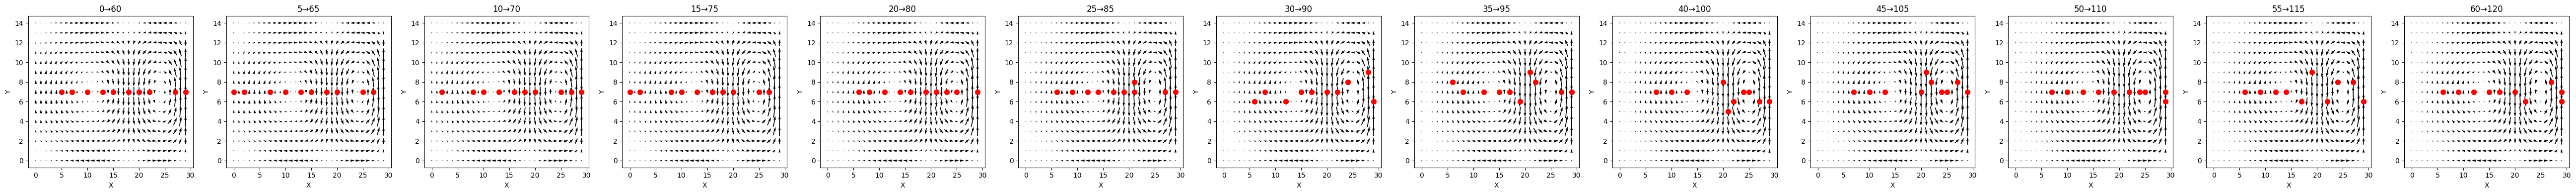

In [535]:
plot_all_intervals(data, nx_t, ny_t, intervals, sensor_coords_list)

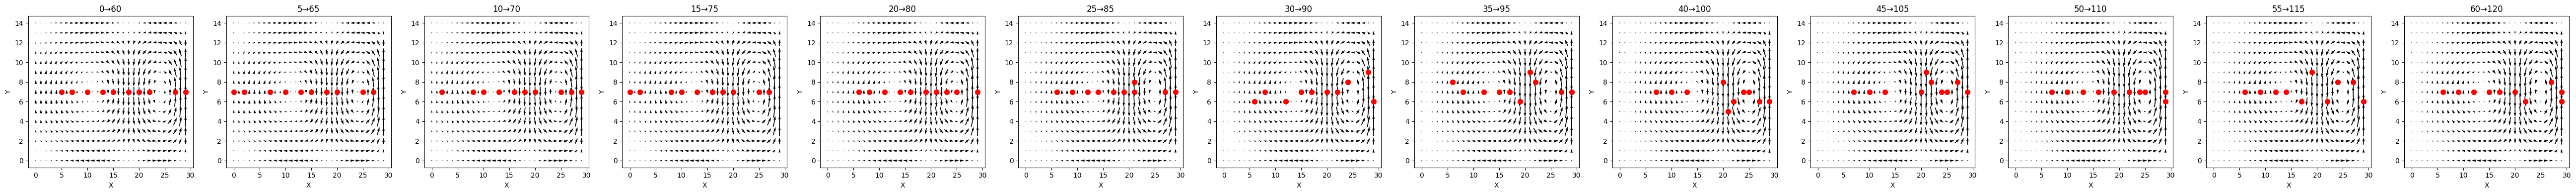

In [536]:
if feild_representation == "concatenation":
    sensor_coords_list = [map_sensor_to_original(sensor_coords, (nx_t, ny_t), horizontal_concat) for sensor_coords in sensor_coords_list]

plot_all_intervals((u_field, v_field), nx, ny, intervals, sensor_coords_list)

# Error Analysis

In [537]:
def rmse(a, b):
    return np.sqrt(np.mean((a - b) ** 2))

In [538]:
rows = []          # to build a DataFrame
horizontal_concat = True
data = combine_vector_fields(u_field, v_field, horizontal_concat=horizontal_concat)

for interval_id, (start, end) in enumerate(intervals):
    data_interval = data[start:end] # augmented (T, nx_t, ny_t)
    X = data_interval.reshape(interval_length, nx_t * ny_t)
    
    # fit + predict
    sensor_idx, _ = get_sspor_sensors(X, n_sensors, n_basis_modes,
                                    is_data_complex=True)
    model_basis = ps.basis.SVD(n_basis_modes=n_basis_modes,
                                complex_mode=True, algorithm='arpack')
    model = ps.SSPOR(n_sensors=n_sensors, basis=model_basis)
    model.fit(X)
    
    # Measurements only at the selected sensor locations
    Y_meas = X[:, sensor_idx]                
    X_pred = model.predict(Y_meas)           
    X_pred = X_pred.astype(X.dtype)          
    
    #back to u,v
    u_true, v_true = split_augmented(X, nx_t, ny_t,
                                    horizontal_concat=horizontal_concat)
    u_pred, v_pred = split_augmented(X_pred, nx_t, ny_t,
                                    horizontal_concat=horizontal_concat)

    
    # polar fields
    r_true = np.sqrt(u_true**2 + v_true**2)
    r_pred = np.sqrt(u_pred**2 + v_pred**2)
    theta_true = np.arctan2(v_true, u_true)
    theta_pred = np.arctan2(v_pred, u_pred)
    
    #  RMSE metrics
    cart_err  = 0.5 * (rmse(u_true, u_pred) + rmse(v_true, v_pred))
    polar_err = 0.5 * (rmse(r_true, r_pred) + rmse(theta_true, theta_pred))
    
    rows.append({
        "interval"       : f"{start}-{end}",
        "representation" : f"{"Concat"}-Cart",   # complex snapshot built from u+iv
        "Cartesian RMSE" : cart_err,
        "Polar RMSE"     : polar_err
    })

err_df = pd.DataFrame(rows)
print(err_df)


ValueError: cannot reshape array of size 54000 into shape (60,450)

In [ ]:
rows   = []          # to build a DataFrame
horizontal_concat = True
data = combine_vector_fields(magnitude, angle, horizontal_concat=horizontal_concat)

for interval_id, (start, end) in enumerate(intervals):
    data_interval = data[start:end] # augmented (T, nx_t, ny_t)
    X = data_interval.reshape(interval_length, nx_t * ny_t)
    
    # fit + predict
    sensor_idx, _ = get_sspor_sensors(X, n_sensors, n_basis_modes,
                                    is_data_complex=True)
    model_basis = ps.basis.SVD(n_basis_modes=n_basis_modes,
                                complex_mode=True, algorithm='arpack')
    model = ps.SSPOR(n_sensors=n_sensors, basis=model_basis)
    model.fit(X)
    
    # Measurements only at the selected sensor locations
    Y_meas = X[:, sensor_idx]                
    X_pred = model.predict(Y_meas)           
    X_pred = X_pred.astype(X.dtype)          
    
    #back to u,v
    u_true, v_true = split_augmented(X,      nx_t, ny_t,
                                    horizontal_concat=horizontal_concat)
    u_pred, v_pred = split_augmented(X_pred, nx_t, ny_t,
                                    horizontal_concat=horizontal_concat)

    
    # polar fields
    r_true = np.sqrt(u_true**2 + v_true**2)
    r_pred = np.sqrt(u_pred**2 + v_pred**2)
    theta_true = np.arctan2(v_true, u_true)
    theta_pred = np.arctan2(v_pred, u_pred)
    
    #  RMSE metrics
    cart_err  = 0.5 * (rmse(u_true, u_pred) + rmse(v_true, v_pred))
    polar_err = 0.5 * (rmse(r_true, r_pred) + rmse(theta_true, theta_pred))
    
    rows.append({
        "interval"       : f"{start}-{end}",
        "representation" : f"{"Concat"}-Polar",   # complex snapshot built from u+iv
        "Cartesian RMSE" : cart_err,
        "Polar RMSE"     : polar_err
    })

err_df = pd.DataFrame(rows)
print(err_df)


   interval representation  Cartesian RMSE  Polar RMSE
0      0-60   Concat-Polar        0.627389    1.203860
1      5-65   Concat-Polar        0.627179    1.115377
2     10-70   Concat-Polar        0.607560    0.998913
3     15-75   Concat-Polar        0.469910    0.840327
4     20-80   Concat-Polar        0.760165    1.739335
5     25-85   Concat-Polar        0.536643    0.854469
6     30-90   Concat-Polar        0.320696    0.470043
7     35-95   Concat-Polar        0.542506    1.106779
8    40-100   Concat-Polar        0.665010    1.256914
9    45-105   Concat-Polar        0.246804    0.486781
10   50-110   Concat-Polar        0.664033    1.254952
11   55-115   Concat-Polar        0.535736    1.412184
12   60-120   Concat-Polar        0.567037    1.179478


# Sensor Flow Feild

In [ ]:
import cv2
import math
from scipy.ndimage import gaussian_filter
from scipy.spatial import cKDTree

In [ ]:
def sensors_to_gaussian_img(coords, nx, ny, sigma=1.3, amp=1.0):
    """
    coords : array (n_sensors,2)  -- integer grid indices (i,j)
    nx, ny : grid dimensions
    sigma  : std‑dev of Gaussian (in pixels)
    returns: 2‑D float image of shape (nx, ny)
    """
    img = np.zeros((nx, ny), dtype=np.float32)
    for i, j in coords:
        img[i, j] = amp                          # delta spike
    if sigma > 0:
        img = gaussian_filter(img, sigma=sigma)  # blur into blob
    # normalize so max=1 (helps optical flow)
    img /= img.max() + 1e-9
    return img

In [548]:
def farneback_from_flow(nx, ny,        # grid resolution   (pixels)
                        lx, ly,        # domain size       (same units as velocity)
                        dt,            # time‑step between frames
                        u_max,         # estimate of max |u| in domain units/sec
                        blob_sigma_px, # Gaussian blur σ used for each sensor (pixels)
                        pyr_scale=0.5  # keep 0.5 
                       ):
    """
    Compute a reasonable Farnebäck parameter dictionary.
    Returns something you can splat straight into calcOpticalFlowFarneback(**params).
    """
    # convert physics to pixel displacements per frame 
    dx = lx / nx  # one pixel in physical units
    disp_px = u_max * dt / dx # max jump in *pixels* per frame

    # pick pyramid depth so residual motion <= 3 px at coarsest
    if disp_px <= 3:
        levels = 1
        residual = disp_px
    else:
        levels = math.ceil(1 + math.log(disp_px / 3, 1 / pyr_scale))
        residual = disp_px * (pyr_scale ** (levels - 1))

    # needs to cover both the blob diameter (≈ 4 σ) and the residual jump
    winsize = int(2 * max(blob_sigma_px * 2, residual))
    if winsize % 2 == 0: # Farnebäck prefers odd windows
        winsize += 1

    poly_n = 5 if max(nx, ny) < 1000 else 7
    poly_sigma = 1.1 if poly_n == 5 else 1.5

    return dict(pyr_scale=pyr_scale,
                levels=levels,
                winsize=winsize,
                iterations=3,  
                poly_n=poly_n,
                poly_sigma=poly_sigma,
                flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN)

In [ ]:
def compute_blob_sigma(sensor_coords_list,
                        target_amp=0.3,
                        mode="max"):
    """
    Compute blob σ so that across ALL timesteps your Gaussian blobs
    overlap at `target_amp` of peak.

    sensor_coords_list : list of (n_sensors,2) arrays or lists of (x,y) tuples
    target_amp         : desired amplitude at neighbor center (0<target_amp<1)
    mode               : "mean" (avg spacing) or "max" (worst-case spacing)
    """
    all_nn_dist = []

    for coords in sensor_coords_list:
        # ensure an (N,2) array of floats
        arr = np.array(coords, dtype=float)
        if arr.ndim != 2 or arr.shape[1] != 2:
            raise ValueError("Each coords entry must be shape (n,2)")

        # build KD-tree & find 2nd neighbor (first is self at zero)
        tree = cKDTree(arr)
        dists, _ = tree.query(arr, k=2)
        nn = dists[:,1] 
        all_nn_dist.append(nn)

    all_nn_dist = np.concatenate(all_nn_dist)

    if mode == "mean":
        d_ref = all_nn_dist.mean()
    elif mode == "max":
        d_ref = all_nn_dist.max()
    else:
        raise ValueError("mode must be 'mean' or 'min'")

    sigma_px = d_ref / math.sqrt(2 * math.log(1/target_amp))
    return sigma_px


In [557]:
compute_blob_sigma(sensor_coords_list)

3.866588135745217

In [558]:
# setting hyper_params
blob_sigma_px = compute_blob_sigma(sensor_coords_list)

frames = [sensors_to_gaussian_img(coord_set, nx, ny, sigma=blob_sigma_px)
          for coord_set in sensor_coords_list]   
frames = np.stack(frames, axis=0)

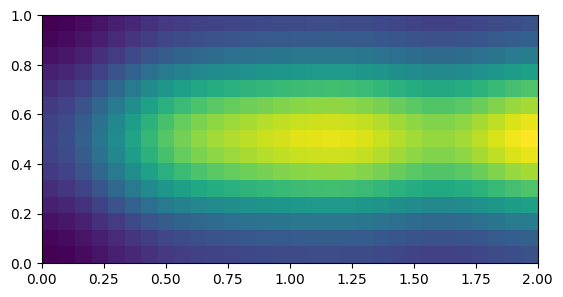

In [559]:
plt.imshow(frames[0].T, origin='lower', extent=[0, lx, 0, ly], cmap='viridis')

In [560]:
dt = period / n_timesteps
u_max = data.max()                    
fb_params = farneback_from_flow(nx, ny, lx, ly, dt,
                                u_max, blob_sigma_px)

In [561]:
flows = []  # will hold (flow_x, flow_y) arrays of shape (nx, ny)
for k in range(len(frames) - 1):
    f0 = frames[k].astype(np.float32)
    f1 = frames[k + 1].astype(np.float32)
    flow = cv2.calcOpticalFlowFarneback(
        prev=f0.T, next=f1.T,   # transpose: OpenCV uses (rows,cols) = (y,x)
        flow=None,
        **fb_params)
    # flow has shape (ny, nx, 2): (vx, vy) in pixel units
    flow = flow.transpose(1, 0, 2)   # back to (nx, ny, 2)
    flows.append(flow)

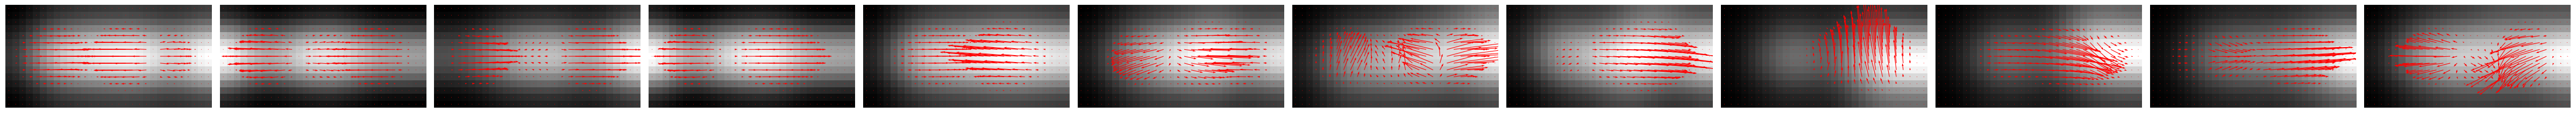

In [562]:
fig, axes = plt.subplots(1, len(flows), figsize=(4*len(flows),4))
for ax, img, flow in zip(axes, frames[:-1], flows):
    ax.imshow(img.T, origin='lower', cmap='gray')
    skip = 1      # thin quiver for clarity
    X, Y = np.meshgrid(np.arange(0, nx, skip), np.arange(0, ny, skip), indexing='ij')
    U = flow[::skip, ::skip, 0];  V = flow[::skip, ::skip, 1]
    ax.quiver(X, Y, U, V, color='red')
    ax.set_axis_off()
plt.tight_layout(); plt.show()